In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)
sns.set_palette("colorblind")          # colour‑blind‑friendly palette
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.right"]  = False
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.frameon"]     = False

In [3]:
data = {
    "Smoothing": [0.0, 0.025, 0.05, 0.1, 0.15, 0.3],
    "AR":        [44.9, 45.6, 46.2, 48.2, 50.5, 60.0],
    "MDLM":      [83.0, 84.2, 84.7, 89.2, 93.6, 111.4],
    "UDLM":      [106.9, 94.4, 92.2, 94.5, 98.9, 121.2],
}
df_wide = pd.DataFrame(data)
df_wide

,Smoothing,AR,MDLM,UDLM
0,0.000,44.9,83.0,106.9
1,0.025,45.6,84.2,94.4
2,0.050,46.2,84.7,92.2
3,0.100,48.2,89.2,94.5
4,0.150,50.5,93.6,98.9
5,0.300,60.0,111.4,121.2


In [5]:
df_long = df_wide.melt(id_vars="Smoothing",
                       value_vars=["AR", "MDLM", "UDLM"],
                       var_name="Model",
                       value_name="Perplexity")

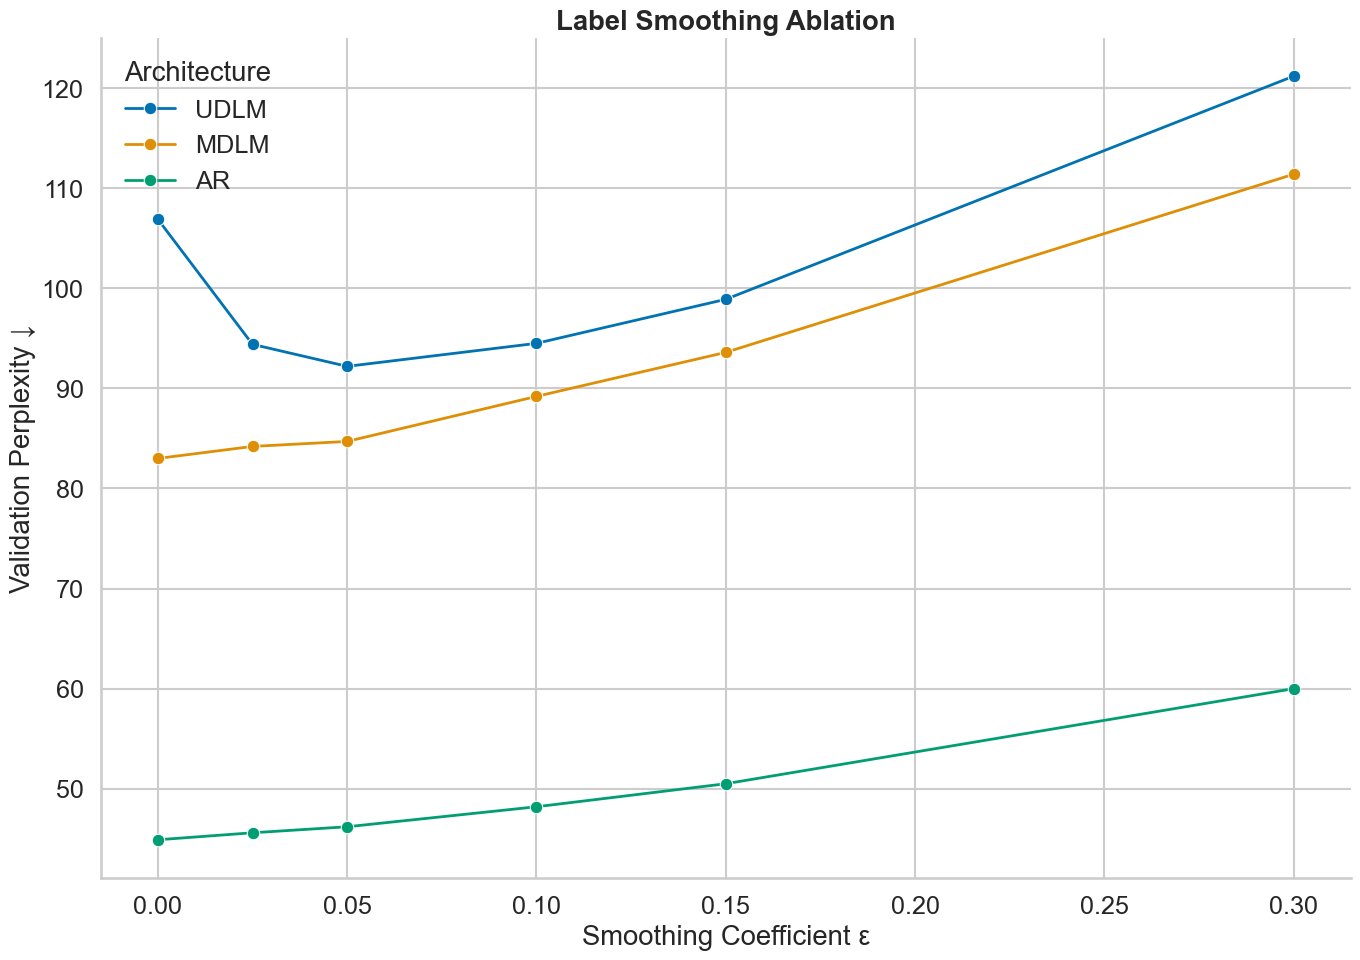

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.lineplot(data=df_long[::-1],
             x="Smoothing",
             y="Perplexity",
             hue="Model",
             marker="o",
             linewidth=2,
             ax=ax)

ax.set_title("Label Smoothing Ablation")
ax.set_xlabel("Smoothing Coefficient ε")
ax.set_ylabel("Validation Perplexity ↓")
# ax.invert_yaxis()          # optional: low perplexity at top
ax.legend(title="Architecture", loc="upper left")

plt.tight_layout()
plt.show()